<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/angle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#en fi ara ve la part que trobem l'angle d'incidencia amb el sol
#suposant que el vector normal al pla de les plaques solars és paral·lel al vector que uneix el centre de la terra amb bellaterra

#necessitem les posicions a la Terra, agafaré durant un any la posició de la Terra cada hora, o sigui 365*24 posicions (de moment Euler que es el que funca)
import numpy as np
import matplotlib.pyplot as plt
import copy

# Dades en unitats del SI
G= 6.67430e-11
m_sol= 1.98847e30
m_terra= 5.97219e24
m_lluna= 7.349e22
m_mart= 6.4171e23

# Condicions inicials (en cartesianes)
# L'origen és el baricentre del sistema solar
# Format: [x,y,z,vx,vy,vz]
# Inici a les 04:42 del 21 de juny del 2025 (solstici d'estiu)
# Això és per el temps central Europeu, per tant hi ha un lleuger error
# Ja que no està a Bellaterra/Barcelona exactament.

#Posicions en kilometres i velocitats en km/s
lluna= np.array([-1.081554325966438E+06, -1.526346829987447E+08, 5.289505218940973E+04,
 2.874182090220137E+01, 6.308874791782940E-01, 6.961580076988511E-02])

terra= np.array([-1.393448650322997E+06, -1.528245787749783E+08, 3.246810235627741E+04,
 2.932512160332670E+01, -2.663812783881785E-01, -1.233690374052812E-03])

sol= np.array([-6.714001826750380E+05, -8.034375730918228E+05, 2.366931954465597E+04,
 1.263663211842965E-02, -3.218117708051999E-03, -2.265135898351946E-04])

mart= np.array([-2.458249892172696E+08, -2.180156046072930E+07, 5.595389337974356E+06,
 2.984615568179249E+00, -2.207313642037887E+01, -5.356157436277602E-01])

# Normalització
t0= 86400.0            # Temps característic= 1 dia
m0= m_sol              # Massa característica= massa del sol
r0= (G * t0**2 * m0)**(1/3)  # Radi característic


lluna= np.concatenate((lluna[:3]*(1/r0)*10**3, lluna[3:]*(t0/r0)*10**3, [m_lluna/m0]))
terra= np.concatenate((terra[:3]*(1/r0)*10**3, terra[3:]*(t0/r0)*10**3, [m_terra/m0]))
sol= np.concatenate((sol[:3]*(1/r0)*10**3, sol[3:]*(t0/r0)*10**3, [m_sol/m0]))
mart= np.concatenate((mart[:3]*(1/r0)*10**3, mart[3:]*(t0/r0)*10**3, [m_mart/m0]))

planetes={"luna": lluna,
          "terra": terra,
          "sol": sol,
          "mars": mart}

def acceleració(Num, terra, sol, lluna, mart):
  if Num=="terra":  #Terra
    dist_s = np.linalg.norm(sol[:3]-terra[:3])**3
    dist_l = np.linalg.norm(lluna[:3]-terra[:3])**3
    dist_m = np.linalg.norm(mart[:3]-terra[:3])**3

    a_x= ((sol[0]-terra[0])/dist_s + lluna[6]*(lluna[0]-terra[0])/dist_l + mart[6]*(mart[0]-terra[0])/dist_m)
    a_y= ((sol[1]-terra[1])/dist_s + lluna[6]*(lluna[1]-terra[1])/dist_l + mart[6]*(mart[1]-terra[1])/dist_m)
    a_z= ((sol[2]-terra[2])/dist_s + lluna[6]*(lluna[2]-terra[2])/dist_l + mart[6]*(mart[2]-terra[2])/dist_m)

    return np.array([a_x, a_y, a_z])

  elif Num=="sol":  #Sol
    dist_t = np.linalg.norm(terra[:3]-sol[:3])**3
    dist_l = np.linalg.norm(lluna[:3]-sol[:3])**3
    dist_m = np.linalg.norm(mart[:3]-sol[:3])**3

    a_x= (terra[6]*(terra[0]-sol[0])/dist_t + lluna[6]*(lluna[0]-sol[0])/dist_l + mart[6]*(mart[0]-sol[0])/dist_m)
    a_y= (terra[6]*(terra[1]-sol[1])/dist_t + lluna[6]*(lluna[1]-sol[1])/dist_l + mart[6]*(mart[1]-sol[1])/dist_m)
    a_z= (terra[6]*(terra[2]-sol[2])/dist_t + lluna[6]*(lluna[2]-sol[2])/dist_l + mart[6]*(mart[2]-sol[2])/dist_m)

    return np.array([a_x, a_y, a_z])

  elif Num=="luna":  #Lluna
    dist_t = np.linalg.norm(terra[:3]-lluna[:3])**3
    dist_s = np.linalg.norm(sol[:3]-lluna[:3])**3
    dist_m = np.linalg.norm(mart[:3]-lluna[:3])**3

    a_x= (terra[6]*(terra[0]-lluna[0])/dist_t + (sol[0]-lluna[0])/dist_s + mart[6]*(mart[0]-lluna[0])/dist_m)
    a_y= (terra[6]*(terra[1]-lluna[1])/dist_t + (sol[1]-lluna[1])/dist_s + mart[6]*(mart[1]-lluna[1])/dist_m)
    a_z= (terra[6]*(terra[2]-lluna[2])/dist_t + (sol[2]-lluna[2])/dist_s + mart[6]*(mart[2]-lluna[2])/dist_m)

    return np.array([a_x, a_y, a_z])

  elif Num=="mars":  #Mart
    dist_t = np.linalg.norm(mart[:3]-terra[:3])**3
    dist_l = np.linalg.norm(mart[:3]-lluna[:3])**3
    dist_s= np.linalg.norm(mart[:3]-sol[:3])**3

    a_x= (terra[6]*(terra[0]-mart[0])/dist_t + (sol[0]-mart[0])/dist_s + lluna[6]*(lluna[0]-mart[0])/dist_l)
    a_y= (terra[6]*(terra[1]-mart[1])/dist_t + (sol[1]-mart[1])/dist_s + lluna[6]*(lluna[1]-mart[1])/dist_l)
    a_z= (terra[6]*(terra[2]-mart[2])/dist_t + (sol[2]-mart[2])/dist_s + lluna[6]*(lluna[2]-mart[2])/dist_l)

    return np.array([a_x, a_y, a_z])
  else:
    return None

#   return sist_sol
def Euler_explícit(sist_sol, dt):
  sist_vell = copy.deepcopy(sist_sol)
  sist_nou = copy.deepcopy(sist_sol)

  # Velocitats (primer perquè Euler-Cromer)
  for j in sist_vell:
    sist_nou[j][3:6] = sist_vell[j][3:6] + dt * acceleració(j, sist_vell["terra"], sist_vell["sol"], sist_vell["luna"], sist_vell["mars"])
  # Posicions
  for j in sist_vell:
    sist_nou[j][:3] = sist_vell[j][:3] + dt * sist_vell[j][3:6]

  return sist_nou


t_f = 365
dt = 1/24
res=[copy.deepcopy(planetes)]
passos = int(t_f/dt) -1
for i in range(passos):
  res.append(copy.deepcopy(Euler_explícit(res[-1],dt)))

from mpl_toolkits.mplot3d import Axes3D

# Extreure trajectòries
x_t, y_t, z_t = [], [], []
x_s, y_s, z_s = [], [], []

for estat in res:
    x_t.append(estat["terra"][0])
    y_t.append(estat["terra"][1])
    z_t.append(estat["terra"][2])

    x_s.append(estat["sol"][0])
    y_s.append(estat["sol"][1])
    z_s.append(estat["sol"][2])
print (len(x_t))

8760


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23.]
[0]
[5771224.91594407]
[2698630.01717285]


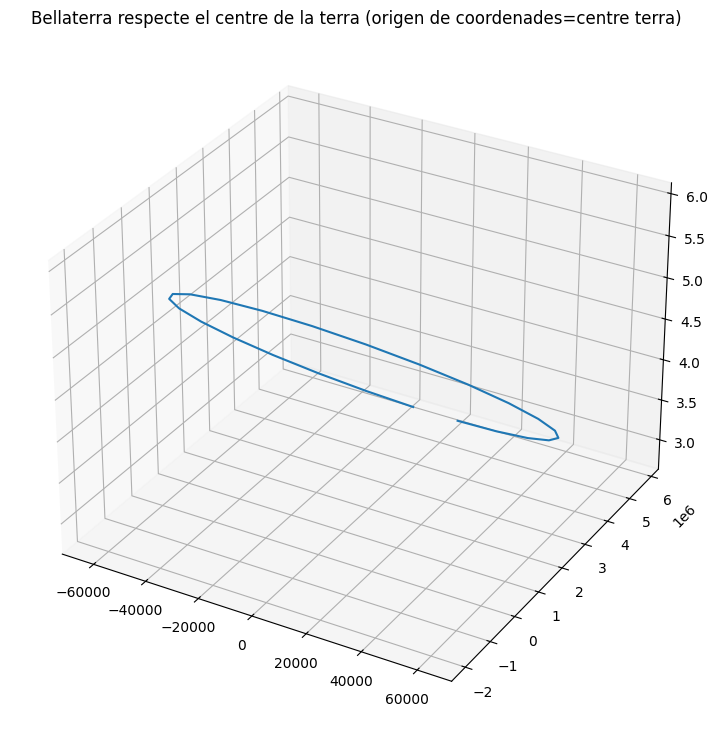

In [ ]:
#per com ho hem fet tenim el vector que uneuix el baricentre del SS amb la Terra i amb el sol
#volem el vector que uneix sol i terra llavors farem el vector baricentre-Terra menys el vector baricentre-Sol

import numpy as np
import matplotlib.pyplot as plt

R_t = 6371000 #metres
vel_ang = 2*np.pi/24 # en rad/h
theta = (23.43333333333333*2*np.pi)/360
phi= (41.505833333*2*np.pi)/360

x =  np.array([0])
y =  np.array([R_t*np.sin(theta + phi)])
z = np.array([R_t*np.cos(theta + phi)])

"""
R[sin(θ +ϕ)cos(ωt) + sin(θ)[sin(θ)sin(θ + ϕ) + cos(θ)cos(θ + ϕ)](1−cos(ωt))]
R[cos(θ)sin(θ + ϕ)−sin(θ)cos(θ + ϕ)]sin(ωt)
R[cos(θ + ϕ)cos(ωt) + cos(θ)[sin(θ)sin(θ + ϕ) + cos(θ)cos(θ + ϕ)](1−cos(ωt))]

"""
t = np.linspace(1,23,23)
print (t)

# aquestes són les coordenades del vector centre terra-bellaterra
x_b = np.concatenate((x,(R_t * np.sin(vel_ang * t))*(np.cos(theta)*np.sin(theta + phi) - np.sin(theta)-np.cos(theta + phi))))
y_b = np.concatenate((y,(np.sin(theta + phi)*np.cos(vel_ang*t) + np.sin(theta)*(np.sin(theta)*np.sin(theta + phi) + np.cos(theta)*np.cos(theta + phi))*(1 - np.cos(vel_ang*t))) * R_t))
z_b = np.concatenate((z,(np.cos(theta + phi)*np.cos(vel_ang*t) + np.cos(theta)*(np.sin(theta)*np.sin(theta + phi) + np.cos(theta)*np.cos(theta + phi))*(1 - np.cos(vel_ang*t))) * R_t))
print(x)
print(y)
print(z)
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_b,y_b,z_b)
ax.set_title("Bellaterra respecte el centre de la terra (origen de coordenades=centre terra)")
plt.show()


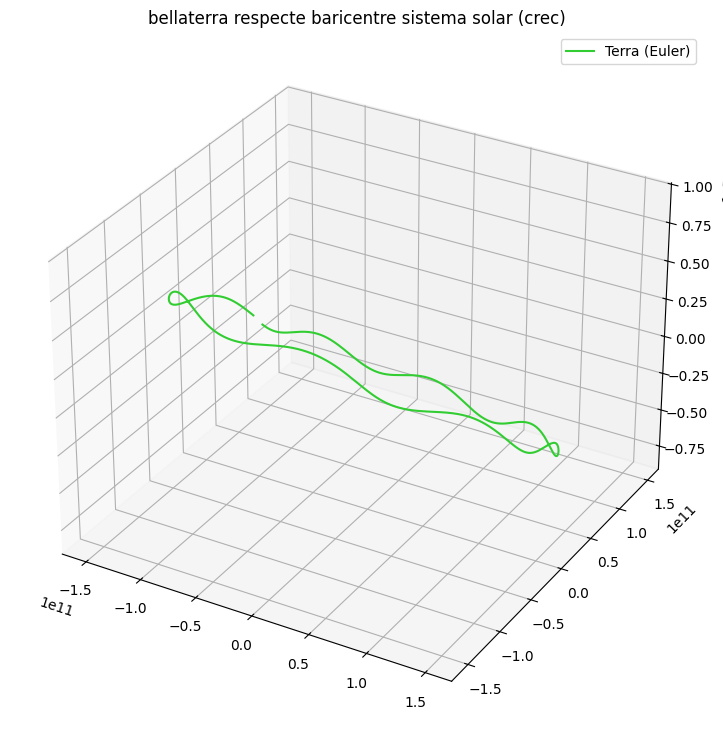

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

x_st = r0 * (np.array(x_t) - np.array(x_s))
y_st = r0 * (np.array(y_t) - np.array(y_s))
z_st = r0 * (np.array(z_t) - np.array(z_s))

X_b = np.array (list(x_b)*365)
Y_b = np.array (list(y_b)*365)
Z_b = np.array (list(z_b)*365)


fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_st, y_st, z_st, label="Terra (Euler)", color="limegreen")
# ax.plot(x_b,y_b,z_b, color="blue", label="vector bellaterra respecte el centre de la terra") no cal, no?
ax.set_title("terra respecte baricentre sistema solar (crec)")
plt.legend()
plt.show()



[-0.90582383 -0.89842911 -0.87372905 ... -0.82226976 -0.87233543
 -0.89717966]
0.0 5771224.9159440715 2698630.0171728507
-722048467.647959 -152021141201.8865 8798782.811621444
-0.9058238296559585


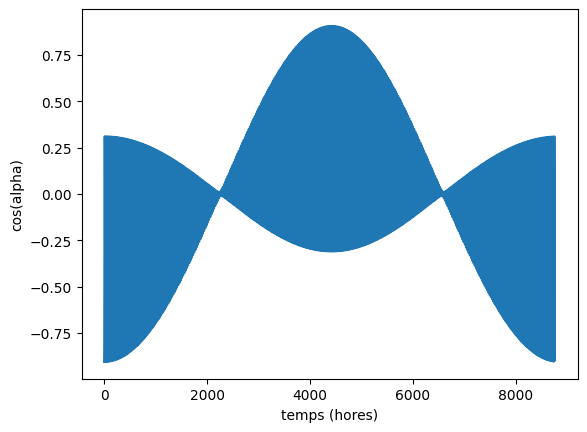

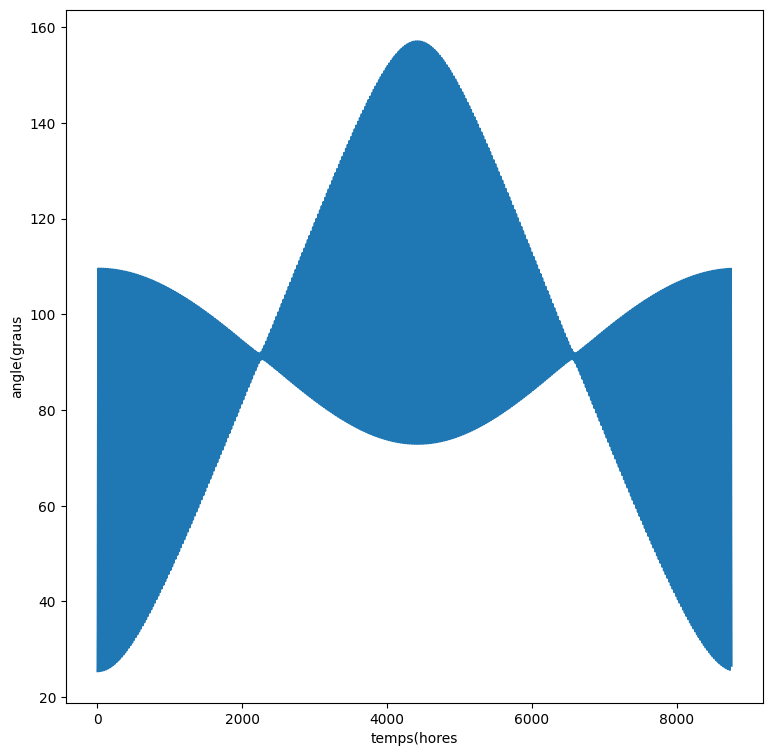

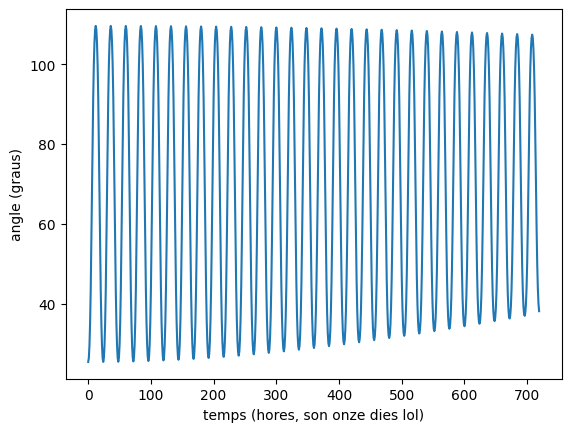

In [ ]:
# HE SEPARAT EL CODI DELS ALTRES GRÀFICS PER COMODITAT PER PODER VEURE EL PRIMER
mod_t = np.sqrt(x_st**2 + y_st**2 + z_st**2)
mod_b = np.sqrt(x_b**2 + y_b**2 + z_b**2)
Mod_b = np.array(list(mod_b) * 365)

cos_llista = (X_b * x_st + Y_b * y_st + Z_b * z_st)/(Mod_b * mod_t)

print(cos_llista)

temps = np.linspace(0,8759,8760)

theta_llista = np.pi - np.arccos(cos_llista)

print(X_b[0],Y_b[0],Z_b[0])
print(x_st[0],y_st[0],z_st[0])


print((X_b[0]*x_st[0]+Y_b[0]*y_st[0]+Z_b[0]*z_st[0])/(np.sqrt(X_b[0]**2+Y_b[0]**2+Z_b[0]**2)*np.sqrt(x_st[0]**2 + y_st[0]**2+ z_st[0]**2)))
plt.plot (temps,cos_llista)
plt.ylabel("cos(alpha)")
plt.xlabel("temps (hores)")
plt.show()

fig = plt.figure(figsize=(7,7)) # Aquesta figura estava a (20,20) però m'ha agobiat vale
plt.plot(temps,theta_llista*365/(2*np.pi))
plt.ylabel("angle(graus")
plt.xlabel("temps(hores")
plt.show()



plt.plot(np.linspace(0,719,720),theta_llista[slice(720)]*365/(2*np.pi))
plt.ylabel("angle (graus)")
plt.xlabel("temps (hores, son onze dies lol)")
plt.show()
#ara ve la part que recordem el producte escalar: mod(v)*mod(u)cos(theta)=v*u

#nota mental aquest producte ens dona l'angle que formen dos vectors amb el mateix origen, si ens fixem nosaltres volem el complementari a aquest, és a dir pi/2 - theta, lol


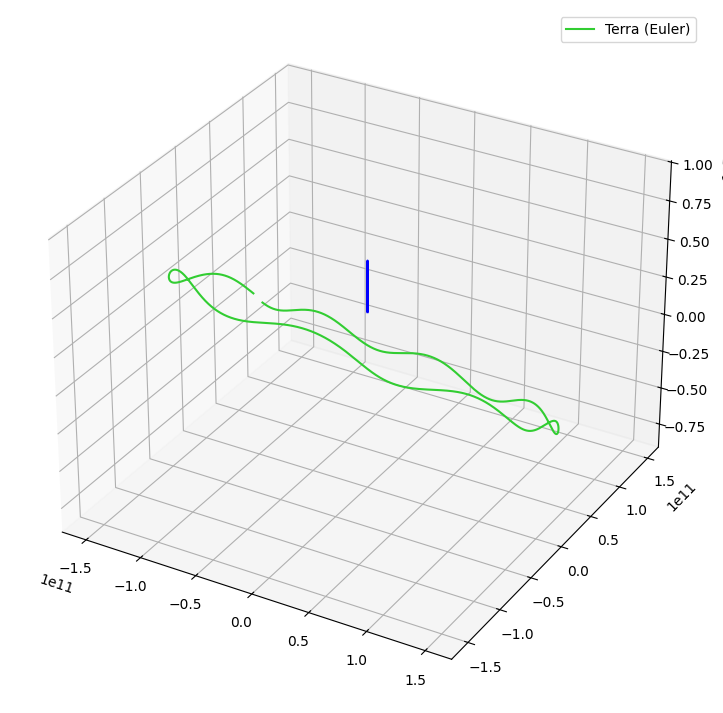

[-0.90582383 -0.89842911 -0.87372905 ... -0.82226976 -0.87233543
 -0.89717966]
0.0 5771224.9159440715 2698630.0171728507
-722048467.647959 -152021141201.8865 8798782.811621444
-0.9058238296559585


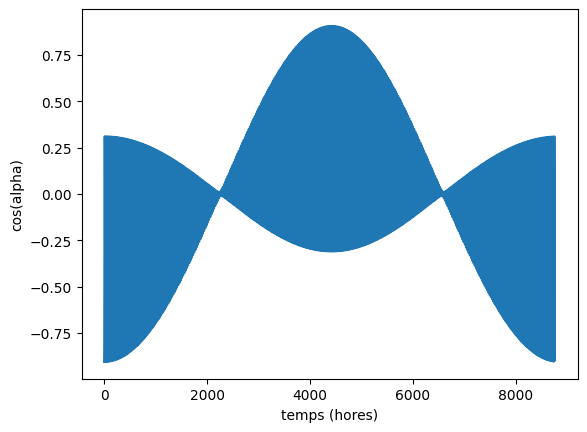

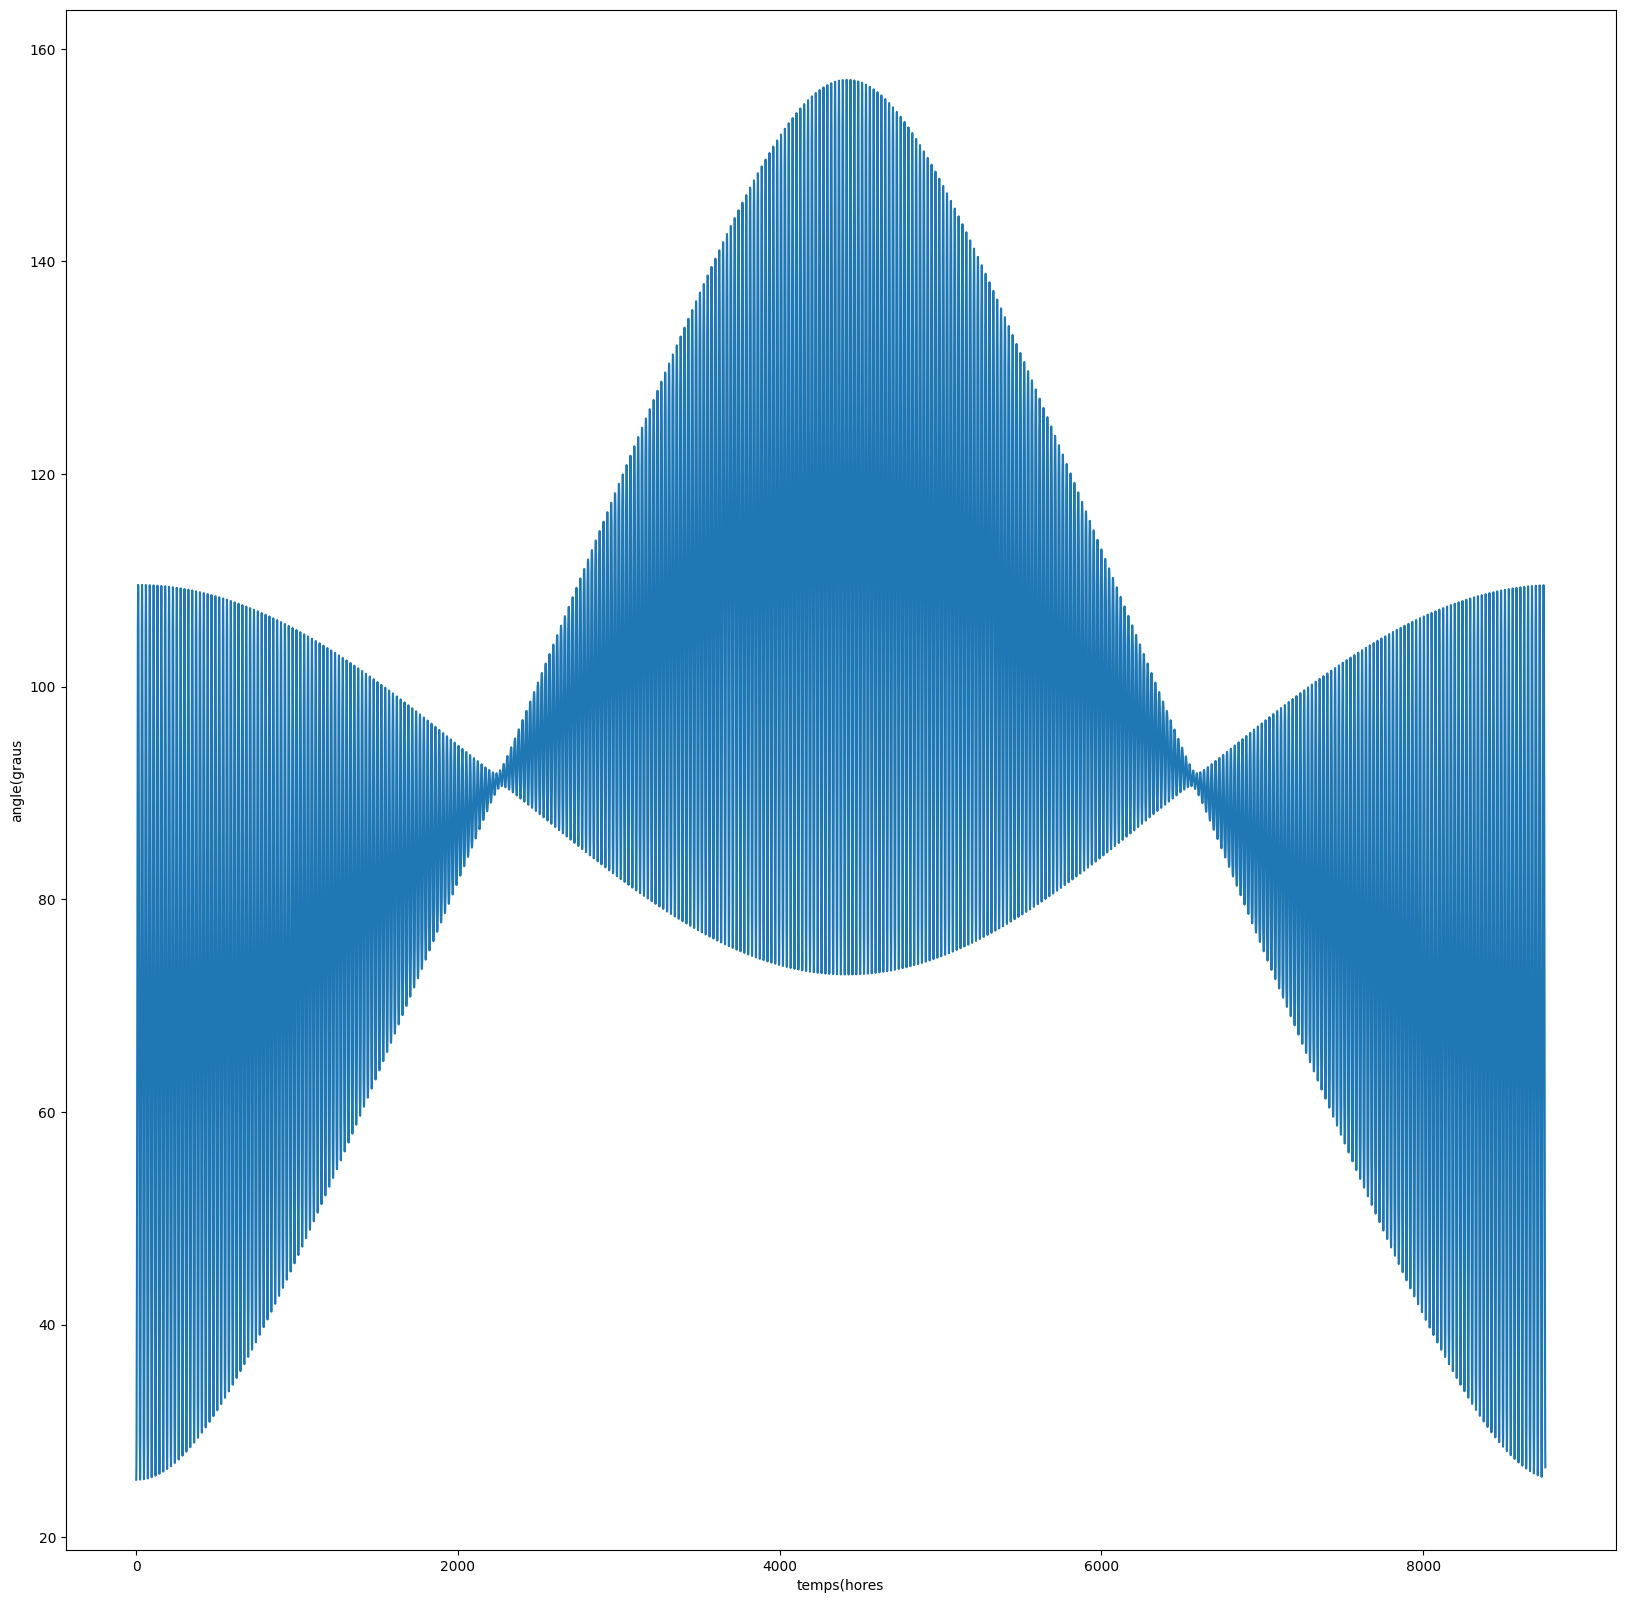

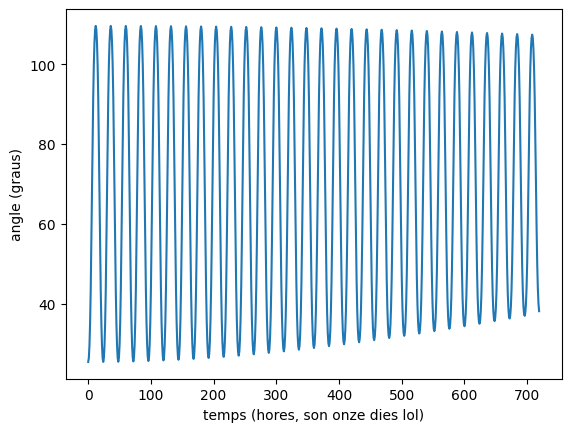

In [ ]:


from mpl_toolkits.mplot3d import Axes3D

x_st = r0 * (np.array(x_t) - np.array(x_s))
y_st = r0 * (np.array(y_t) - np.array(y_s))
z_st = r0 * (np.array(z_t) - np.array(z_s))

X_b = np.array (list(x_b)*365)
Y_b = np.array (list(y_b)*365)
Z_b = np.array (list(z_b)*365)


fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_st, y_st, z_st, label="Terra (Euler)", color="limegreen")
ax.plot(x_b,y_b,z_b, color="blue")
plt.legend()
plt.show()

mod_t = np.sqrt(x_st**2 + y_st**2 + z_st**2)
mod_b = np.sqrt(x_b**2 + y_b**2 + z_b**2)
Mod_b = np.array(list(mod_b) * 365)

cos_llista = (X_b * x_st + Y_b * y_st + Z_b * z_st)/(Mod_b * mod_t)

print(cos_llista)

temps = np.linspace(0,8759,8760)

theta_llista = np.pi - np.arccos(cos_llista)

print(X_b[0],Y_b[0],Z_b[0])
print(x_st[0],y_st[0],z_st[0])


print((X_b[0]*x_st[0]+Y_b[0]*y_st[0]+Z_b[0]*z_st[0])/(np.sqrt(X_b[0]**2+Y_b[0]**2+Z_b[0]**2)*np.sqrt(x_st[0]**2 + y_st[0]**2+ z_st[0]**2)))
plt.plot (temps,cos_llista)
plt.ylabel("cos(alpha)")
plt.xlabel("temps (hores)")
plt.show()

fig = plt.figure(figsize=(20,20))
plt.plot(temps,theta_llista*365/(2*np.pi))
plt.ylabel("angle(graus")
plt.xlabel("temps(hores")
plt.show()



plt.plot(np.linspace(0,719,720),theta_llista[slice(720)]*365/(2*np.pi))
plt.ylabel("angle (graus)")
plt.xlabel("temps (hores, son onze dies lol)")
plt.show()
#ara ve la part que recordem el producte escalar: mod(v)*mod(u)cos(theta)=v*u

#nota mental aquest producte ens dona l'angle que formen dos vectors amb el mateix origen, si ens fixem nosaltres volem el complementari a aquest, és a dir pi/2 - theta, lol



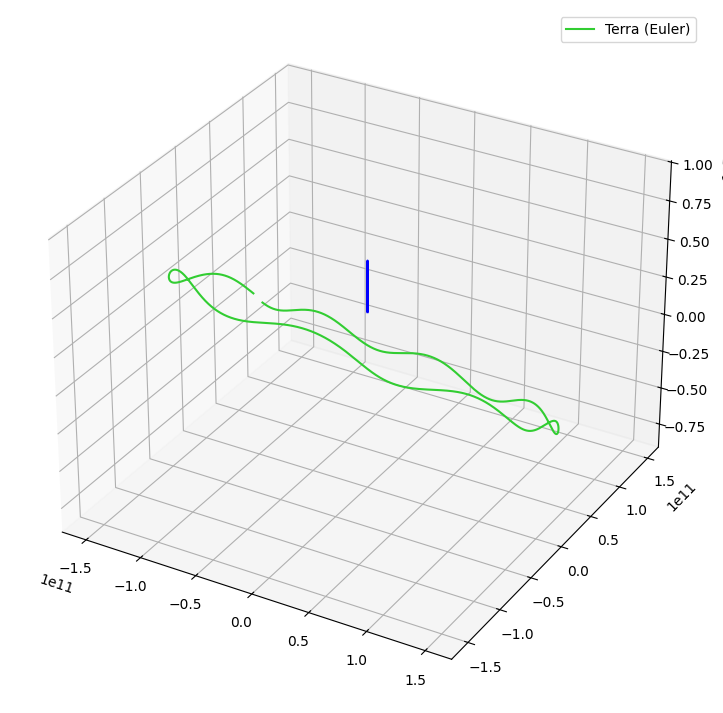

[-0.90582383 -0.89842911 -0.87372905 ... -0.82226976 -0.87233543
 -0.89717966]
0.0 5771224.9159440715 2698630.0171728507
-722048467.647959 -152021141201.8865 8798782.811621444
-0.9058238296559585


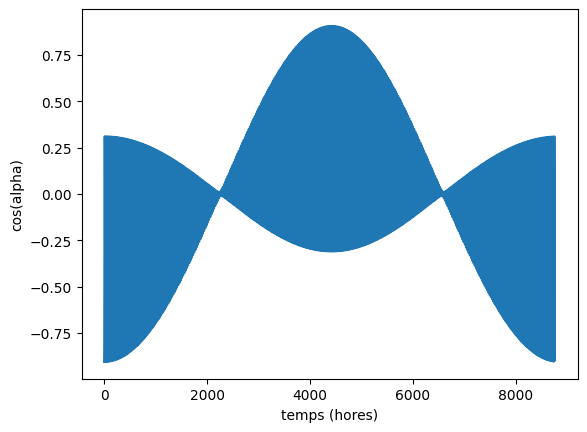

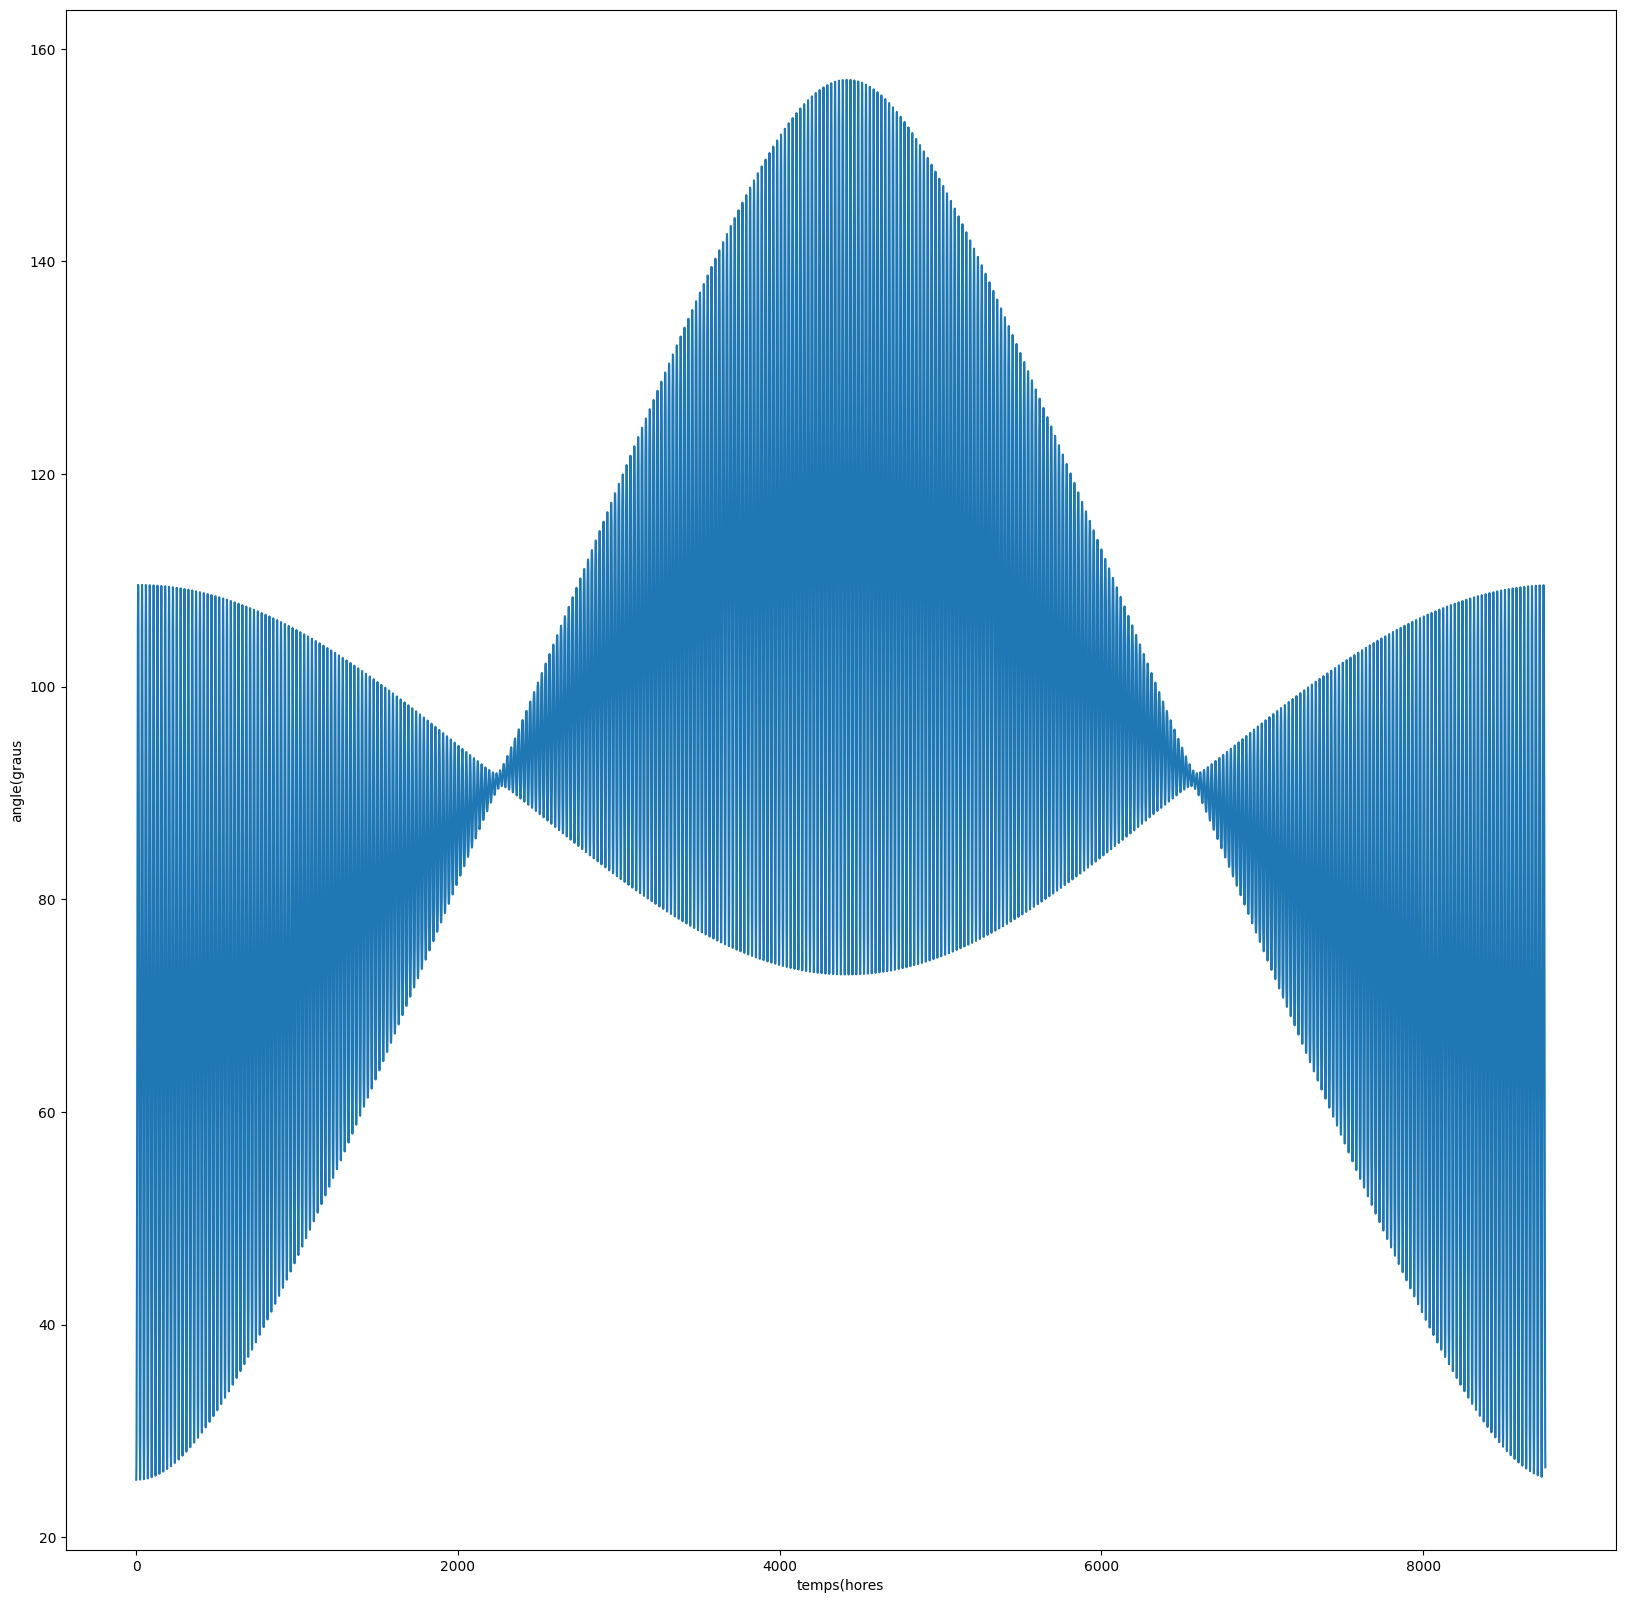

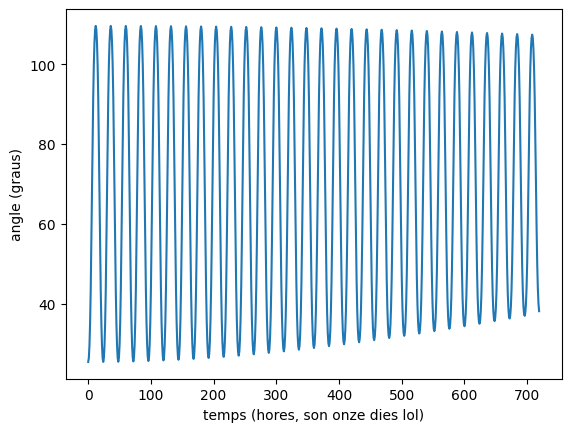

In [ ]:

from mpl_toolkits.mplot3d import Axes3D

x_st = r0 * (np.array(x_t) - np.array(x_s))
y_st = r0 * (np.array(y_t) - np.array(y_s))
z_st = r0 * (np.array(z_t) - np.array(z_s))

X_b = np.array (list(x_b)*365)
Y_b = np.array (list(y_b)*365)
Z_b = np.array (list(z_b)*365)


fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_st, y_st, z_st, label="Terra (Euler)", color="limegreen")
ax.plot(x_b,y_b,z_b, color="blue")
plt.legend()
plt.show()

mod_t = np.sqrt(x_st**2 + y_st**2 + z_st**2)
mod_b = np.sqrt(x_b**2 + y_b**2 + z_b**2)
Mod_b = np.array(list(mod_b) * 365)

cos_llista = (X_b * x_st + Y_b * y_st + Z_b * z_st)/(Mod_b * mod_t)

print(cos_llista)

temps = np.linspace(0,8759,8760)

theta_llista = np.pi - np.arccos(cos_llista)

print(X_b[0],Y_b[0],Z_b[0])
print(x_st[0],y_st[0],z_st[0])


print((X_b[0]*x_st[0]+Y_b[0]*y_st[0]+Z_b[0]*z_st[0])/(np.sqrt(X_b[0]**2+Y_b[0]**2+Z_b[0]**2)*np.sqrt(x_st[0]**2 + y_st[0]**2+ z_st[0]**2)))
plt.plot (temps,cos_llista)
plt.ylabel("cos(alpha)")
plt.xlabel("temps (hores)")
plt.show()

fig = plt.figure(figsize=(20,20))
plt.plot(temps,theta_llista*365/(2*np.pi))
plt.ylabel("angle(graus")
plt.xlabel("temps(hores")
plt.show()



plt.plot(np.linspace(0,719,720),theta_llista[slice(720)]*365/(2*np.pi))
plt.ylabel("angle (graus)")
plt.xlabel("temps (hores, son onze dies lol)")
plt.show()
#ara ve la part que recordem el producte escalar: mod(v)*mod(u)cos(theta)=v*u

#nota mental aquest producte ens dona l'angle que formen dos vectors amb el mateix origen, si ens fixem nosaltres volem el complementari a aquest, és a dir pi/2 - theta, lol

